## Portfolio Optimalization - Asset Management
#### Arno Goedhuys /  r0636556 / 29 juni 2017

In [923]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm
from scipy import interpolate
%matplotlib inline

#### Downloading the data
The data is downloaded from google finance. 
<p> The time interval runs from the first of january 2009 to the current date.

In [1094]:
assets = ['SBUX','GOOGL','ADBE','TRV','UNH','VZ','WMT','GS','DD','AXP','AAPL','MSFT','AMZN','YHOO','KO','CSCO','JPM','UTX','V','MCD','DIS', 'NKE','INTC','GE', 'PG', 'JNJ','HD','IBM','MMM']
amount_of_assets = len(assets)
print 'amount of assets: ', amount_of_assets
#amount_of_assets = 5
pf_data = pd.DataFrame()

for asset in assets:
    pf_data[asset] = wb.DataReader(asset, data_source = 'google', start='2009-1-1')['Close']

amount of assets:  29


In [1095]:
amount_of_trading_days = len(pf_data.index)
pf_data.tail()

,SBUX,GOOGL,ADBE,TRV,UNH,VZ,WMT,GS,DD,AXP,...,MCD,DIS,NKE,INTC,GE,PG,JNJ,HD,IBM,MMM
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-19,58.11,992.77,148.92,126.46,189.19,43.45,75.87,222.87,85.35,85.93,...,153.89,106.82,57.77,34.56,26.94,88.35,135.21,153.30,147.53,212.10
2017-07-20,58.03,992.19,149.94,124.57,191.50,44.22,76.02,222.30,84.83,85.35,...,154.21,107.36,59.10,34.75,26.69,88.60,136.57,147.03,147.66,212.45
2017-07-21,57.98,993.84,149.52,125.15,191.78,44.23,76.15,220.18,84.54,85.59,...,153.92,107.09,59.95,34.73,25.91,88.61,135.31,146.65,147.08,211.16
2017-07-24,58.02,998.31,149.53,126.38,190.89,43.71,76.89,218.18,84.35,85.00,...,151.85,107.00,58.95,34.50,25.43,88.18,133.01,144.58,145.99,210.00
2017-07-25,58.55,969.03,148.21,127.46,190.40,43.98,78.52,221.58,85.49,85.41,...,159.07,106.42,59.39,34.67,25.44,89.14,131.88,146.97,146.19,199.39


#### Normalize data
Devide each value of each asset by its initial value and multipy by 100 so each asset starts with a value of 100. <p> Plot the evolution of each asset.

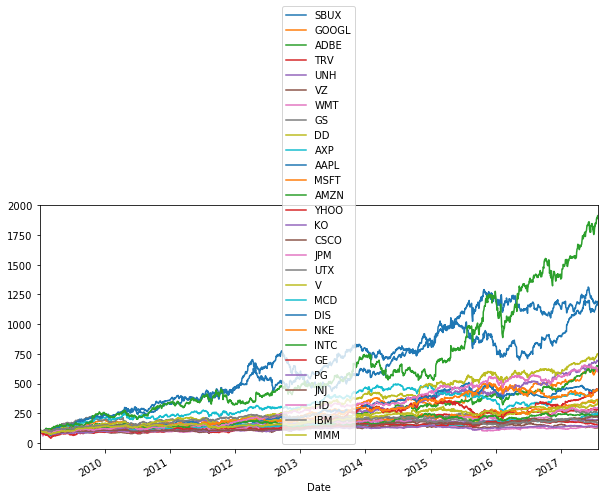

In [1096]:
normalized_data = pf_data / pf_data.iloc[0] * 100
(normalized_data).plot(figsize=(10,5))

1723


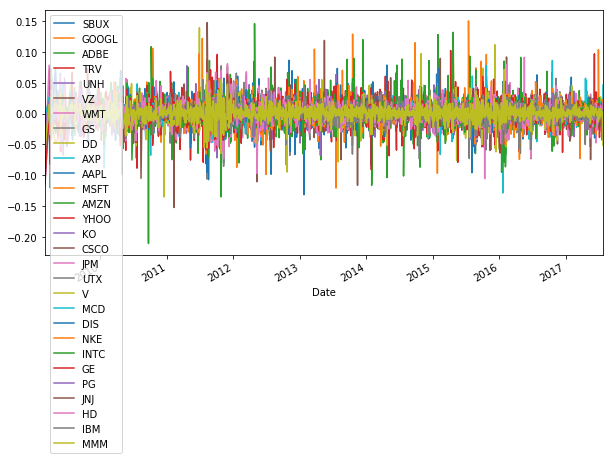

In [1097]:
probabilities = [x for x in range(len(normalized_data))]
daily_returns1 = np.log(normalized_data / normalized_data.shift(1))
daily_returns2 = daily_returns1.sample(frac=0.8,weights = probabilities)
amount_of_trading_days = len(normalized_data.index)
daily_returns = daily_returns2.sort_index(ascending = True)
print len(daily_returns) #daily_returns.tail(), len(daily_returns), daily_returns1.tail(20)
(daily_returns).plot(figsize=(10,5))

In [1098]:
df = pd.DataFrame()
k=0
for i in range(5):
    df[i] = [k,k+1,k+2,k+3,k+4]
    k+=5
df.sample(frac=0.5)

,0,1,2,3,4
2,2,7,12,17,22
3,3,8,13,18,23
1,1,6,11,16,21


#### Calculate the return and risk of a portfolio given the portfolio's assets and their respective weights
A function to generate a given amount of random weights while making sure the sum of the weights equals 1.

In [1099]:
def gen_random_weights(amount):
    weights = np.random.random(amount)
    weights /= np.sum(weights)
    return weights
print gen_random_weights(amount_of_assets)

[ 0.04045368  0.04933055  0.0295943   0.01173751  0.04601289  0.07018578
  0.0339377   0.02013599  0.0305748   0.05139417  0.00640109  0.07213489
  0.06432697  0.00151081  0.06205758  0.01525226  0.0256796   0.00768932
  0.01263768  0.03059274  0.07002925  0.06977999  0.00975265  0.04143989
  0.05134995  0.0032407   0.02805898  0.00951262  0.03519566]


A function to calculate the expected annual return of the portfolio.
The expected annual return of a portfolio can be calculated as: $$ p = w^T*E(r) $$
Where w is the weights of the respective portfolios and E(r) the expected anual returns of the assets.
The expected anual return of an individual asset is calculated as the expected daily return times 252 which is the amount of trading days. The expected daily return is calculated as the expected value of the logarithm of the assets current value devided by its previous value. So the expected anual return of an asset is given by: $$ E(r) = 252 * E(\log(P_i/P_{i+1})) $$
Where $P_i$ represents the assets price on day i and $P_{i+1}$ the assets price on day i+1.

In [1100]:
def portfolio_return(D_returns, weights):
    annual_returns = D_returns.mean() * 252
    total_return = np.sum(annual_returns * weights)
    return total_return

portfolio_return(daily_returns, gen_random_weights(amount_of_assets))


0.1297652775253224

A function to calculate the expected volatility of a portfolio. The volatility is modelled as the standard deviation of portfolios returns. This be calculated as: $$ \sigma^2 = w^T*C*w $$
Where w is again the weights of the assets and C is the covariance matrix of the returns.

In [1101]:
def portfolio_volatility(D_returns, weights):
    cov_matrix = D_returns.cov() * 252
    total_volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
    return total_volatility

portfolio_volatility(daily_returns, gen_random_weights(amount_of_assets))

0.14338264739271125

In [1102]:
def portfolio_covariance_matrix(D_returns):
    annual_returns = D_returns.mean() * 252
    cov_matrix = D_returns.cov() * 252
    cov_matrix = cov_matrix.values
    annual_returns = matrix(annual_returns)
    cov_matrix = matrix(cov_matrix)
    return cov_matrix
print portfolio_covariance_matrix(daily_returns)

[ 5.84e-02  2.54e-02  2.99e-02  1.73e-02  2.04e-02  1.29e-02  1.30e-02 ... ]
[ 2.54e-02  5.63e-02  2.75e-02  1.42e-02  1.80e-02  1.17e-02  9.44e-03 ... ]
[ 2.99e-02  2.75e-02  7.33e-02  1.97e-02  2.07e-02  1.27e-02  1.16e-02 ... ]
[ 1.73e-02  1.42e-02  1.97e-02  3.30e-02  1.79e-02  1.23e-02  1.07e-02 ... ]
[ 2.04e-02  1.80e-02  2.07e-02  1.79e-02  5.57e-02  1.00e-02  1.09e-02 ... ]
[ 1.29e-02  1.17e-02  1.27e-02  1.23e-02  1.00e-02  2.75e-02  9.49e-03 ... ]
[ 1.30e-02  9.44e-03  1.16e-02  1.07e-02  1.09e-02  9.49e-03  2.77e-02 ... ]
[ 2.60e-02  2.51e-02  3.28e-02  2.60e-02  2.47e-02  1.46e-02  1.21e-02 ... ]
[ 2.25e-02  1.91e-02  2.53e-02  1.90e-02  1.91e-02  1.40e-02  1.06e-02 ... ]
[ 2.63e-02  2.19e-02  2.77e-02  1.98e-02  2.23e-02  1.37e-02  1.19e-02 ... ]
[ 2.26e-02  2.44e-02  2.29e-02  1.27e-02  1.73e-02  1.05e-02  8.87e-03 ... ]
[ 2.37e-02  2.48e-02  2.89e-02  1.70e-02  1.82e-02  1.33e-02  1.12e-02 ... ]
[ 3.15e-02  3.83e-02  3.28e-02  1.66e-02  2.01e-02  1.23e-02  9.38e-03 ... ]

In [1103]:
def max_return(D_returns):
    annual_returns = D_returns.mean() * 252
    #print annual_returns
    return max(annual_returns)
max_return(daily_returns)

0.30821326602279181

#### Functions to return the parameters that need to be optimized with their weights as variables 
They are all calculated the same way as their numeric functions previously defined only the weights are variables instead of numeric values. Parameters that have to be maximized are taken negatively because the optimizations look for minimal values and the weights that give the maximal value are the same weights that given the minimal negative value.

The return in function of the weights.

In [1048]:
def returns(x):
    #amount_of_assets = len(normalized_data.columns)
    annual_returns = daily_returns.mean() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -np.sum(annual_returns * variable)

The risk in function of the weights.

In [1049]:
def risk(x):
    #amount_of_assets = len(normalized_data.columns)
    cov_matrix = daily_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable)))


The sharp ratio in function of the weights. The sharp ratio is the return devided by the risk.

In [1050]:
def sharp(x):
    #amount_of_assets = len(normalized_data.columns)
    #log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = daily_returns.mean() * 252
    cov_matrix = daily_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -(np.sum(annual_returns * variable)-risk_free_rate) / (np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable)))) 

#### Extra funtions usefull for the optimization


The contraint for the optimization, that the sum of the weights must be equal to one. 

In [937]:
def constraint1(x):
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return np.sum(variable) - 1

In [938]:
def constraint3(x):
    #log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = daily_returns.mean() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -np.sum(annual_returns * variable)-0.2151833

A function to generate the valid interval for each weight.

In [939]:
def gen_bounds(amount):
    bounds = []
    for i in range(amount):
        bounds.append((0,0.5))
    return bounds

Make an initial guess by brute force to give the optimazation a good starting point.

In [908]:
def initial_guess(assets, amount_of_samples):
    min_risk = 1
    min_risk_weights = gen_random_weights(amount_of_assets)
    max_sharp = 0
    max_sharp_weights = gen_random_weights(amount_of_assets)
    max_VaR = -1
    max_VaR_weights = gen_random_weights(amount_of_assets)
    max_CVaR = -1
    max_CVaR_weights = gen_random_weights(amount_of_assets)
    for x in range(amount_of_samples):
        weights = gen_random_weights(amount_of_assets)
        port_risk = portfolio_volatility(assets, weights)
        port_return = portfolio_return(assets, weights)
        port_VaR = HistoricVaR(assets, weights, 0.05)
        port_CVaR = HistoricCVaR(assets, weights, 0.05)
        if port_risk < min_risk:
            min_risk = port_risk
            min_risk_weights = weights
        if port_return/port_risk > max_sharp:
            max_sharp = port_return/port_risk
            max_sharp_weights = weights
        if port_VaR > max_VaR:
            max_VaR = port_VaR
            max_VaR_weights = weights
        if port_CVaR > max_CVaR:
            max_CVaR = port_CVaR
            max_CVaR_weights = weights
    var = HistoricVaR(assets, max_CVaR_weights, 0.05)
    max_CVaR_weights = np.append(max_CVaR_weights,var)
    #print max_CVaR
    return [min_risk_weights, max_sharp_weights, max_VaR_weights, max_CVaR_weights]
initial_guess(normalized_data,1000)

[array([ 0.02587414,  0.07063182,  0.12085082,  0.013769  ,  0.1002123 ,
         0.01679498,  0.08498564,  0.0372692 ,  0.14081984,  0.13019245,
         0.15786453,  0.10073526]),
 array([  2.38448372e-03,   1.82096467e-01,   2.69792885e-03,
          1.64772136e-01,   1.18818090e-01,   8.35716895e-02,
          2.18214391e-01,   5.86501980e-02,   1.03297229e-04,
          1.36907922e-01,   2.33693964e-02,   8.41400079e-03]),
 array([ 0.09361791,  0.10253931,  0.02523048,  0.17052782,  0.17177188,
         0.00738114,  0.03125418,  0.0051405 ,  0.07700398,  0.16478029,
         0.03275803,  0.1179945 ]),
 array([ 0.09361791,  0.10253931,  0.02523048,  0.17052782,  0.17177188,
         0.00738114,  0.03125418,  0.0051405 ,  0.07700398,  0.16478029,
         0.03275803,  0.1179945 , -0.04811935])]

#### The optimizations
The optimization for the minimal risk portfolio. The extra constraints that each weight lies between 0 and 0.5 are set by the 
bounds attribute. The optimization used is the sequantial least squares programming. The site PyOpt explains it as:
> SLSQP optimizer is a sequential least squares programming algorithm which uses the Han–Powell quasi–Newton method with a BFGS update of the B–matrix and an L1–test function in the step–length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver. 
>
> [PyOpt](http://www.pyopt.org/reference/optimizers.slsqp.html)

In [1104]:
#minimal_risk_weights = optimize.fmin_slsqp(risk, initial_guess(normalized_data,100)[0].tolist(),eqcons=[constraint1],
#                     bounds=gen_bounds(amount_of_assets))
minimal_risk_weights = convert_weights(convex_optimizer_weights(daily_returns, 0))
return_minimal_risk = portfolio_return(daily_returns, minimal_risk_weights)
print return_minimal_risk

0.0986936114315


The optimization for the maximal sharp portfolio. The same algorithm is used as with the minimal risk.

In [1105]:
#maximal_sharp_weights = optimize.fmin_slsqp(sharp, initial_guess(normalized_data,1000)[1].tolist(),eqcons=[constraint1],
#                     bounds=gen_bounds(amount_of_assets))
#f = Efficient_Frontier(normalized_data, 300)
#g = Efficient_Frontier(new_normalized_data, 300)
#def find_intersect(f,g,x0):
#     return optimize.fsolve(lambda x : f(x) - g(x),x0)
#find_intersect(f,g,0.22)

#### The results
The two optimized portfolios are plotted on a graph with the x axis the expected risk and the y axis the expected return. To illustrate that these are valid values 25000 other portfolio's with random weights are also plotted on the same graph. Out of the 25000 random portfolio's the one with the minimal risk is selected and returned to verify with the calculated weights, the same is done for the maximal sharp. 

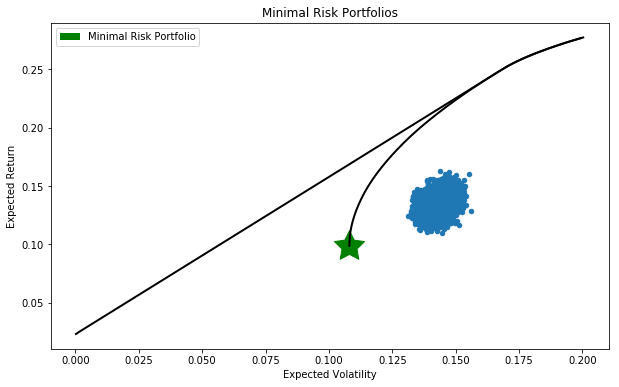

[array([  1.76021135e-03,   6.00746490e-02,   2.28920150e-02,
          5.69240047e-02,   4.10800727e-05,   2.17294425e-02,
          7.34165883e-02,   2.11424971e-02,   3.81154524e-02,
          1.94441923e-02,   2.82738162e-02,   1.25074872e-03,
          1.59867358e-02,   4.88323189e-02,   7.46539398e-02,
          1.72199464e-02,   2.65490887e-02,   8.64626123e-03,
          2.39210397e-02,   7.26119238e-02,   2.02364067e-02,
          3.02968376e-02,   1.28923972e-02,   3.15892675e-02,
          5.08613654e-02,   3.26879656e-02,   6.15523970e-02,
          6.02370308e-02,   6.61603802e-02]),
 array([ 0.05694128,  0.05538345,  0.03938661,  0.01226274,  0.04961359,
         0.03274157,  0.02515568,  0.04486774,  0.02800281,  0.00142703,
         0.0346209 ,  0.0108395 ,  0.09504159,  0.00783108,  0.0071696 ,
         0.00085021,  0.03607071,  0.0494123 ,  0.06624448,  0.0669665 ,
         0.05319133,  0.03019001,  0.00369262,  0.0175895 ,  0.06301177,
         0.05338566,  0.0521300

In [1112]:
def example_plot(D_returns, amount_of_samples):
    returns = []
    risks = []
    amount_of_assets = len(D_returns.columns)
    #efficient_risks = np.arange(0.2052,0.245,0.00004)
    #efficient_returns = [0 for x in range(len(efficient_risks))]
    #new_risk = [0 for x in range(len(efficient_risks))]
    min_risk = 1
    min_risk_weights = gen_random_weights(amount_of_assets)
    max_sharp = 0
    max_sharp_weights = gen_random_weights(amount_of_assets)
    for x in range(amount_of_samples):
        weights = gen_random_weights(amount_of_assets)
        port_risk = portfolio_volatility(D_returns, weights)
        risks.append(port_risk)
        port_return = portfolio_return(D_returns, weights)
        returns.append(port_return)
        if port_risk < min_risk:
            min_risk = port_risk
            min_risk_weights = weights
        if port_return/port_risk > max_sharp:
            max_sharp = port_return/port_risk
            max_sharp_weights = weights
       # for x in range(len(efficient_risks)-1):
      #      if port_risk > efficient_risks[x] and port_risk < efficient_risks[x+1] and port_return > efficient_returns[x]:
     #           efficient_returns[x] = port_return
    #            new_risk[x] = port_risk
    
    #del new_risk[-1]
    #del efficient_returns[-1]
    #deleted_amount = 0
    #for x in range(len(efficient_returns)):
    #    k = x-deleted_amount
    #    if k>0 and efficient_returns[k] < max(efficient_returns[:k]) or efficient_returns[k] == 0:
    #        del efficient_returns[k]
    #        del new_risk[k]
    #        deleted_amount += 1
    #efficient_returns
    #new_risk = np.array(new_risk)
    #z = np.polyfit(new_risk, efficient_returns, 5)
    #f = np.poly1d(z)
    #f = interpolate.interp1d(new_risk, efficient_returns, kind='cubic') 
    #xnew = new_risk
    #ynew = f(xnew) 
    
    
    returns = np.array(returns)
    risks = np.array(risks)
    portfolios = pd.DataFrame({'Return': returns, 'Volatility': risks})
    portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10,6))
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    #plt.plot(xnew, ynew, 'k', linewidth=6.0)
    Efficient_Frontier(new_daily_returns, 400)
    Efficient_Frontier(D_returns, 400)
    
    port_minrisk = portfolio_volatility(D_returns, np.array(minimal_risk_weights))
    port_return = portfolio_return(D_returns, minimal_risk_weights)
    plt.scatter(port_minrisk,port_return,marker=(5,1,0),color='g',s=1000)
    
    #port_maxsharp = portfolio_volatility(assets, maximal_sharp_weights)
    #port_return = portfolio_return(assets, maximal_sharp_weights)
    #plt.scatter(port_maxsharp,port_return,marker=(5,1,0),color='r',s=1000)
    
    #plt.title("Minimal Risk and Maximal Sharp Ratio")
    plt.title("Minimal Risk Portfolios")
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='g')
    #p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='r')

    #plt.legend((p1, p2), ('Minimal Risk Portfolio', 'Maximal Sharp Ratio'), loc='best')
    plt.legend((p1,), ('Minimal Risk Portfolio',), loc='best')
    plt.show()
    return [min_risk_weights, max_sharp_weights, minimal_risk_weights, maximal_sharp_weights]
example_plot(daily_returns, 5000)

The first array is the best minimal risk portfolio out of the 25000 random portfolios.
The third array represents the portfolio that was calculated in the minimal risk optimalization.
The second array is the best maximal sharp ratio portfolio out of the 25000 random portfolios.
The fourth array represents the portfolio that was calculated in the maximal sharp ratio optimalization.

### Different optimization techniques

The objective function in case of the minimal risk portfolio is a quadratic and convex problem. 

In [1106]:
from cvxopt import matrix
from cvxopt.blas import dot
from cvxopt.solvers import qp, options
def convex_optimizer_weights(D_returns, minimal_return):
    options['show_progress'] = False
    n = len(D_returns.columns)
    #log_returns = np.log(assets / assets.shift(1))
    annual_returns = D_returns.mean() * 252
    cov_matrix = D_returns.cov() * 252
    cov_matrix = cov_matrix.values
    annual_returns = matrix(annual_returns)
    cov_matrix = matrix(cov_matrix)
    P = cov_matrix
    q = matrix(np.zeros((n, 1)))
    #G = matrix(np.concatenate((
    #             -np.transpose(np.array(annual_returns)), 
    #             -np.identity(n),np.identity(n)), 0))
    #h = matrix(np.concatenate((
    #             -np.ones((1,1))*minimal_return, 
    #              np.ones((n,1))*0.5,np.ones((n,1))*0.5), 0))
    G = matrix(np.concatenate((
                 -np.transpose(np.array(annual_returns)), 
                 -np.identity(n)), 0))
    h = matrix(np.concatenate((
                 -np.ones((1,1))*minimal_return, 
                  np.zeros((n,1))), 0))
    A = matrix(1.0, (1,n))
    b = matrix(1.0)
    weights = qp(P, q, G, h, A, b)
    return [weights['x'], weights['primal objective']]
print convex_optimizer_weights(daily_returns, 0.25)


[<29x1 matrix, tc='d'>, 0.01419541022159174]


In [1107]:
def convert_weights(weights):
    optimum_weights = []
    for x in weights[0]:
            optimum_weights.append(x)
    return optimum_weights

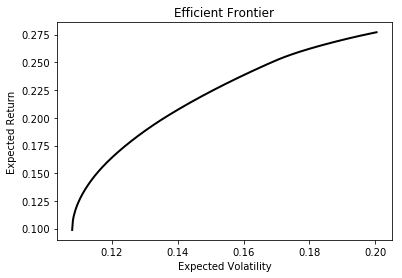

In [1108]:
def Efficient_Frontier(D_returns, amount_of_points, plot=True):
    opt_returns = []
    opt_risks = []
    optimum_weights = []
    minimal_risk_return = portfolio_return(D_returns, np.array(convert_weights(convex_optimizer_weights(D_returns,0))))
    for i in range(amount_of_points):
        optimum_weights = []
        opt_weights = convex_optimizer_weights(D_returns, minimal_risk_return+i*(max_return(D_returns)-minimal_risk_return-0.03)/amount_of_points)
        #opt_weights = np.array(opt_weights)
        optimum_weights = convert_weights(opt_weights)
        opt_returns.append(portfolio_return(D_returns, optimum_weights))
        optimum_weights = np.array(optimum_weights)
        #print optimum_weights
        #opt_risks.append(np.sqrt(opt_weights[1]))
        opt_risks.append(portfolio_volatility(D_returns, optimum_weights))
    f = interpolate.interp1d(opt_risks, opt_returns, kind='cubic') 
    xnew = np.arange(opt_risks[0],opt_risks[-2],(opt_risks[-2]-opt_risks[0])/amount_of_points)
    ynew = f(xnew)
    plt.title("Efficient Frontier")
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    if plot:
        plt.plot(xnew, ynew, 'k', linewidth=2.0)
    return f
Efficient_Frontier(daily_returns, 400)

### Risk free rate

The risk free rate is taken as the 10 year yield of the US treasury bond. Current yield : [Bloomberg Markets](https://www.bloomberg.com/markets/rates-bonds/government-bonds/us)

In [1109]:
risk_free_rate = 0.0232 # current 10 year yield on US treasury bond
#risk_free_return = [100*(1+0.0232/252.0)**x for x in range(amount_of_trading_days)]
risk_free_return = [0.0232/252.0 for x in range(len(daily_returns))]
risk_free_return = np.array(risk_free_return)
new_daily_returns = daily_returns.assign(risk_free=pd.Series(risk_free_return).values)
new_daily_returns.tail()

,SBUX,GOOGL,ADBE,TRV,UNH,VZ,WMT,GS,DD,AXP,...,DIS,NKE,INTC,GE,PG,JNJ,HD,IBM,MMM,risk_free
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-19,-0.001719,0.005880,0.006940,0.007381,0.012446,0.002073,-0.004340,-0.001972,0.015944,0.004783,...,0.010067,0.002079,0.000868,0.001858,-0.003277,0.005562,0.007398,-0.042921,0.003732,0.000092
2017-07-20,-0.001378,-0.000584,0.006826,-0.015058,0.012136,0.017566,0.001975,-0.002561,-0.006111,-0.006773,...,0.005042,0.022761,0.005483,-0.009323,0.002826,0.010008,-0.041760,0.000881,0.001649,0.000092
2017-07-21,-0.000862,0.001662,-0.002805,0.004645,0.001461,0.000226,0.001709,-0.009582,-0.003424,0.002808,...,-0.002518,0.014280,-0.000576,-0.029660,0.000113,-0.009269,-0.002588,-0.003936,-0.006091,0.000092
2017-07-24,0.000690,0.004488,0.000067,0.009780,-0.004652,-0.011826,0.009671,-0.009125,-0.002250,-0.006917,...,-0.000841,-0.016821,-0.006645,-0.018699,-0.004865,-0.017144,-0.014216,-0.007439,-0.005509,0.000092
2017-07-25,0.009093,-0.029768,-0.008867,0.008509,-0.002570,0.006158,0.020978,0.015463,0.013425,0.004812,...,-0.005435,0.007436,0.004915,0.000393,0.010828,-0.008532,0.016395,0.001369,-0.051845,0.000092


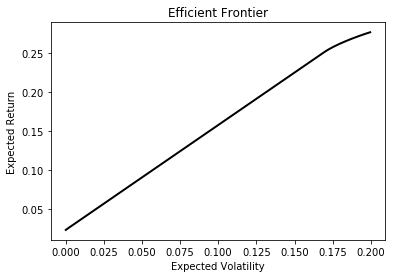

In [1110]:
Efficient_Frontier(new_daily_returns, 400)

In [1111]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)
print is_pos_def(portfolio_covariance_matrix(new_daily_returns)), is_pos_def(portfolio_covariance_matrix(daily_returns))

True True


### Different risk parameters


#### 1. VaR (Value at Risk)

Value at risk describes the worst losses at a given confidence level $ \alpha $ and over a given time period t. VaR can be calculated in two ways by taking the largest return in the $\alpha$ % interval of worst returns or by assuming the returns are normal and deriving the VaR from the mean and standard deviation.

First some functions that will be useful later are given.

In [272]:
def portfolio_daily_returns(assets, weights):
    returns = (assets.shift(1) - assets)/ assets
    portfolio_returns = returns.dot(weights)
    return portfolio_returns.drop(portfolio_returns.index[0])
portfolio_daily_returns(normalized_data, gen_random_weights(amount_of_assets)).head()

Date
2009-01-05   -0.010760
2009-01-06   -0.012958
2009-01-07    0.025111
2009-01-08   -0.023052
2009-01-09    0.012220
dtype: float64

First the VaR will be calculated by selecting the largest return in the lowest interval.

In [257]:
def HistoricVaR(assets, weights, alpha):
    return np.percentile(portfolio_daily_returns(assets,weights), alpha)
HistoricVaR(normalized_data, gen_random_weights(amount_of_assets), 0.05)

-0.067497245133756031

This method is more accurate than assuming a normal distribution because returns are not perfectly normal, but this method can not be used for optimization because every return is in function of the weights so it is unknown where the $ \alpha $ interval ends.

By assuming the returns follow a normal distribution, the VaR can be calculated as: $ VaR = \mu - F^{-1}(\alpha)* \sigma $. First a function to do this nurmerically then in function of the weights.

In [258]:
def normalVaR(assets, weights, alpha):
    var = portfolio_return(assets, weights) - norm.ppf(1-alpha) * portfolio_volatility(assets, weights)
    return var
normalVaR(normalized_data, gen_random_weights(amount_of_assets), 0.05)

-0.15483146492386771

In [259]:
def Var(x):
    log_returns = np.log(normalized_data / normalized_data.shift(1))
    annual_returns = log_returns.mean() * 252
    cov_matrix = log_returns.cov() * 252
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    return -(np.sum(annual_returns * variable) - 1.65 * np.sqrt(np.dot(variable.T,np.dot(cov_matrix, variable))))


In [261]:
minimal_Var_weights = optimize.fmin_slsqp(Var, initial_guess(normalized_data,1000)[2].tolist(),eqcons=[constraint1],
                     bounds=gen_bounds(amount_of_assets))
print minimal_Var_weights, portfolio_return(normalized_data, minimal_Var_weights),portfolio_volatility(normalized_data, minimal_Var_weights)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0883821335378
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 6
[ 0.5         0.11224243  0.32576283  0.06199474] 0.284601931788 0.226050948682


#### Conditional Value at risk
The Var expects the stocks returns to follow a perfect normal distribution. In reality when a stocks price falls hard it triggers other investors to sell, thus the large losses do not drop as quickly as the normal distribution supposes. Therefor it might be useful to take the expected value of the worst returns instead of the start of the 95% interval.

In [262]:
def HistoricCVaR(assets, weights, alpha):
    VaR = HistoricVaR(assets, weights, alpha)
    cVaR = np.nanmean(portfolio_daily_returns(assets, weights)[portfolio_daily_returns(assets, weights) < VaR])
    return cVaR
weight = gen_random_weights(amount_of_assets)
print HistoricCVaR(normalized_data, weight, 0.05) , HistoricVaR(normalized_data, weight, 0.05)

-0.0730809112731 -0.0722376857957


In [263]:
def daily_returns(x):
    data = []
    returns = (normalized_data.shift(1) - normalized_data) / normalized_data
    variable = []
    for i in range(amount_of_assets):
        variable.append(x[i])
    variable = np.array(variable)
    for i in range(len(normalized_data.index)):
        data.append(-np.array(returns.iloc[i]).dot(variable))
    return data
#daily_returns(gen_random_weights(amount_of_assets))

In [264]:
len(normalized_data.index)

2153

In [265]:
weights = gen_random_weights(amount_of_assets)
print weights, np.array(normalized_data.iloc[2]).dot(weights)

[ 0.36579243  0.21782725  0.20113306  0.21524726] 102.753409759


In [270]:
def CVaR(x):
    data = []
    returns = (normalized_data.shift(1) - normalized_data) / normalized_data
    variable = []
    for i in range(amount_of_assets+1):
        variable.append(x[i])
    variable = np.array(variable)
    for i in range(len(normalized_data.index)):
        data.append(np.array(returns.iloc[i]).dot(variable[0:-1]))
    som = 0
    for i in range(len(normalized_data.index)):
        if i>0:
        #not np.isnan(max(data[i]-variable[0],0)): 
            som += max(data[i]-variable[-1],0)
    som = som/float(len(normalized_data.index))
    #print som
    return variable[-1] + 1/(1-0.95) * som
CVaR(gen_random_weights(amount_of_assets+1))
    

0.30992147979124512

In [267]:
def bounds(amount):
    bounds = []
    for i in range(amount):
        bounds.append((0,0.5))
    bounds.append((-0.5,0.5))
    return bounds

In [271]:
minimal_CVaR_weights = optimize.fmin_slsqp(CVaR, initial_guess(normalized_data,1000)[3].tolist(),eqcons=[constraint1],
                     bounds=bounds(amount_of_assets))
print minimal_CVaR_weights, portfolio_return(normalized_data, minimal_CVaR_weights[:-1]),portfolio_volatility(normalized_data, minimal_CVaR_weights[:-1]),HistoricCVaR(normalized_data,  minimal_CVaR_weights[:-1], 0.05)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0308142710345
            Iterations: 21
            Function evaluations: 157
            Gradient evaluations: 21
[ 0.3701338   0.35040658  0.09244963  0.18700999  0.02136954] 0.224527216235 0.205744321127 -0.0626853116943
